In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle 
%matplotlib inline 


def plot_two_image(img1, img2, title1='', title2='', figsize=(24, 9), cm1 = None,cm2 = None):
   
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    ax1.imshow(img1,cmap=cm1)
    ax1.set_title(title1, fontsize=25)
    ax2.imshow(img2,cmap=cm2)
    ax2.set_title(title2, fontsize=25)
    plt.show()

In [2]:



# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
   
    def update(self, x, y):
        """
        Updates the line representation.
        Input Parameters
            x: list of x values        
            y: list of y values
        """
        assert len(x) == len(y), 'x and y have to be the same size'

        self.allx = x
        self.ally = y

        self.n_pixel_per_frame.append(len(self.allx))
        self.recent_xfitted.extend(self.allx)

        if len(self.n_pixel_per_frame) > self.n_frames:
            n_x_to_remove = self.n_pixel_per_frame.pop(0)
            self.recent_xfitted = self.recent_xfitted[n_x_to_remove:]

        self.bestx = np.mean(self.recent_xfitted)

        self.current_fit = np.polyfit(self.allx, self.ally, 2)

        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_frames - 1) + self.current_fit) / self.n_frames

        self.current_fit_poly = np.poly1d(self.current_fit)
        self.best_fit_poly = np.poly1d(self.best_fit)
        

    def is_parallel_to(self, other_line, threshold=(0, 0)):
        """
        Checks if two lines are parallel by comparing their first two coefficients.
        :param other_line: Line to compare to
        :param threshold: Tuple of float values representing the delta thresholds for the coefficients.
        :return:
        """
        first_coefi_dif = np.abs(self.current_fit[0] - other_line.current_fit[0])
        second_coefi_dif = np.abs(self.current_fit[1] - other_line.current_fit[1])

        is_parallel = first_coefi_dif < threshold[0] and second_coefi_dif < threshold[1]

        return is_parallel

    def get_current_fit_distance(self, other_line):
        """
        Gets the distance between the current fit polynomials of two lines
        :param other_line:
        :return:
        """
        return np.abs(self.current_fit_poly(719) - other_line.current_fit_poly(719))

    def get_best_fit_distance(self, other_line):
        """
        Gets the distance between the best fit polynomials of two lines
        :param other_line:
        :return:
        """
        return np.abs(self.best_fit_poly(719) - other_line.best_fit_poly(719))



def calibrate_camera ():
    """
     Calculates the camera's falalowing features:
        1) Camera Matrix used for perfective
        2) distortion coefficients
        3) rotation vectors
        4) Translation vectors 
    returns:
        calibration paramaters
        
    """
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.




    images = glob.glob('camera_cal/calibration*.jpg')

    # Make a list of calibration images
    for fname in images:

        img = cv2.imread(fname)


        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            plt.imsave('output_images/'+ fname,img )
            #print(fname)
        
        ret, mtx, dist, rvecs,tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:-1], None, None) 
        
        calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'ret': ret,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
        return calibration
            
        
try:
    with open("calibrations.picle", "rb") as f:
            calibration = pickle.load(f)
except OSError as err:
    print("Camera Calibration will be done below")    
    calibration = calibrate_camera()
    with open("calibrations.picle", 'wb') as f:
        pickle.dump(calibration, file=f)        


The calibration operation and the result  is saved as pickle file. It can easyly optained if needed. Calibration images are saved in `output_images/camera_cal` folder.

In [3]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):

    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from vertical
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sxbinary


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    
    sobelImgx = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    sobelImgy = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    sobelImg = np.sqrt((sobelImgx**2)+(sobelImgy**2))
    binary_output = np.zeros_like(sobelImg)
    
    scaled_sobel = np.uint8(255*sobelImg / np.max(sobelImg))
    
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    sobelImgx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel))
    sobelImgy = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel))
        
    sobelImg = np.arctan2(sobelImgy, sobelImgx)
    
    binary_output = np.zeros_like(sobelImg)
    
    
    binary_output[(sobelImg > thresh[0]) & (sobelImg < thresh[1])] = 1
    
    return binary_output



def get_thresholded_image(img):
 
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    imshape = gray.shape
    
    # applying gradient threshold on the horizontal gradient
    x_binary = abs_sobel_thresh(gray, 'x', 5, (50,255))
    y_binary = abs_sobel_thresh(gray, 'y', 5, (50,255))
    
    # applying gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, sobel_kernel=9,  thresh=(0.7, 1.3))
    
    mag_thresh_img = mag_thresh(gray, thresh=(50, 255),sobel_kernel=9)
    # combine the gradient and direction thresholds.
    combined_condition = ((x_binary == 1) & (dir_binary == 1))
    
   
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    
 
    s_thresh = (170, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])

    # combine all the thresholds
    # A pixel should either can be   yellowish 
    # And it  also have a gradient perd direction and magnitude
    combined = np.zeros_like(gray)
   
    combined[ (x_binary == 1) | ((mag_thresh_img == 1) & (dir_binary == 1)) | (s_condition )  ] = 1
    # combined[((x_binary == 1) & (y_binary == 1)) | ((mag_thresh_img == 1) & (dir_binary == 1))| (s_condition )] = 1
    mask = np.zeros_like(combined)
    region_of_interest_vertices = np.array([[(imshape[1]*0.05,imshape[0]),
                       (imshape[1]*0.45, imshape[0]*0.63), 
                       (imshape[1]*0.55, imshape[0]*0.63), 
                       (imshape[1]*0.90,imshape[0]*0.90)]], dtype=np.int32)
    
    #region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combined, mask)
    
    return thresholded

In the above script, I used multiple methods of edge detections to detect the edges from the image and used the masking function to avoid having any noises.

Here are 5 methods that I used for edge. 


* Sober Operator x-direction
* Sober Operator y-direction
* Direction of Gradient
* Magnitude of Gradient
* HLS Color Threshold

different combinations are checked and sattled on combination above. 

Now that I have a function for the edge detection I can go to next phase. 

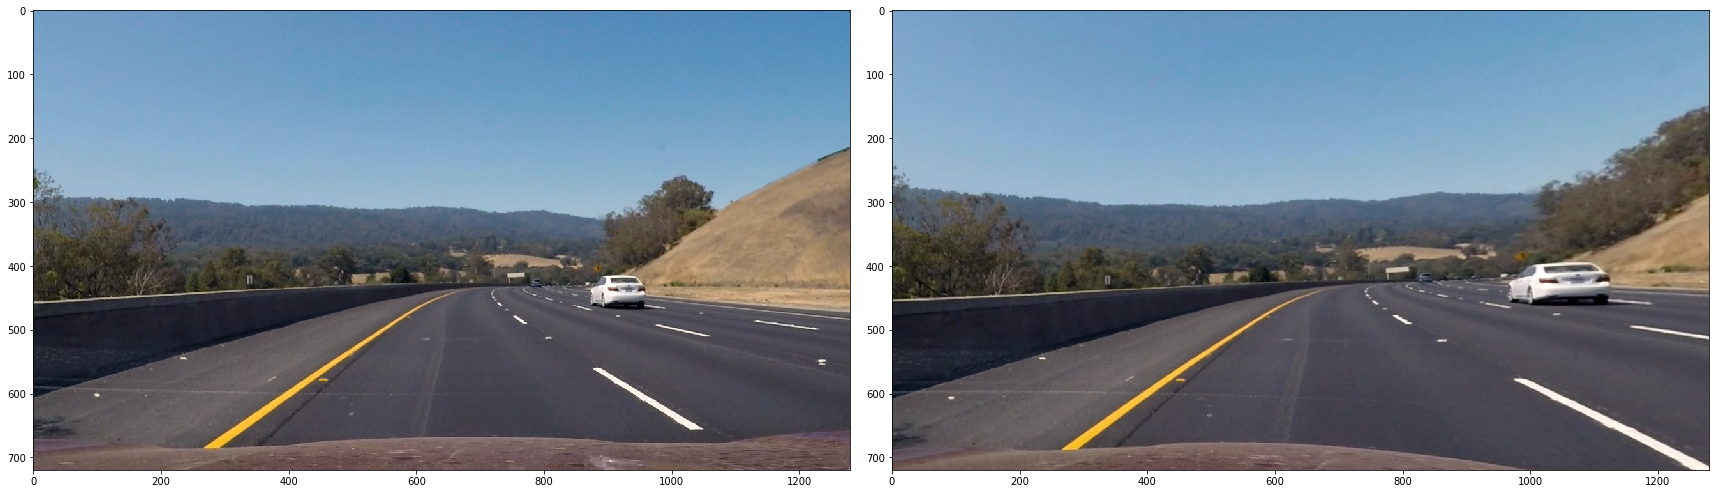

In [3]:
fname = 'test_images/test{}.jpg'.format(3)
img_raw = mpimg.imread(fname)

undist  = cv2.undistort(img_raw, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
plot_two_image(img_raw,undist)

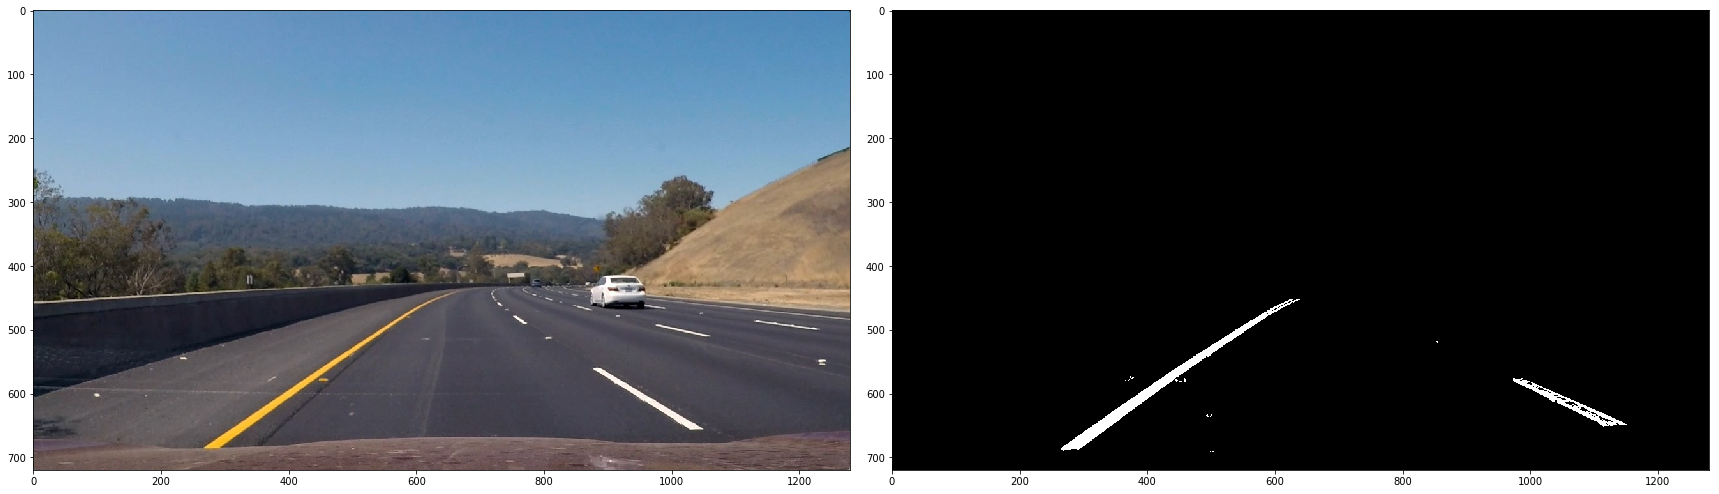

In [4]:

img = get_thresholded_image(undist)
plot_two_image(img_raw,img,cm2='gray')
#TODO: improvement will lead better results

Above is result of the trashold and camera calibration. 


In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img,src, dst, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
   
    
    img_size = img.shape[: : -1]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size,cv2.INTER_CUBIC)
   
    # Return the resulting image and matrix
    return warped, M, Minv

print("corner_unwarp is created")

corner_unwarp is created


In the code below for better perspevctive transform I choose the upper and lower part  of the lanelines I finded. Since upper part and lower part must match in horizantal distance it can clearly be used in perspective transform as key points. 
There for firstly I devided the image in to to portion. One for left lane and the other for right lane. Then I finded the laneline max and min cordinates in the image. Then I used them in perspective transform operation. 

But due to changes in the first laneline the method does't worked as expected. 

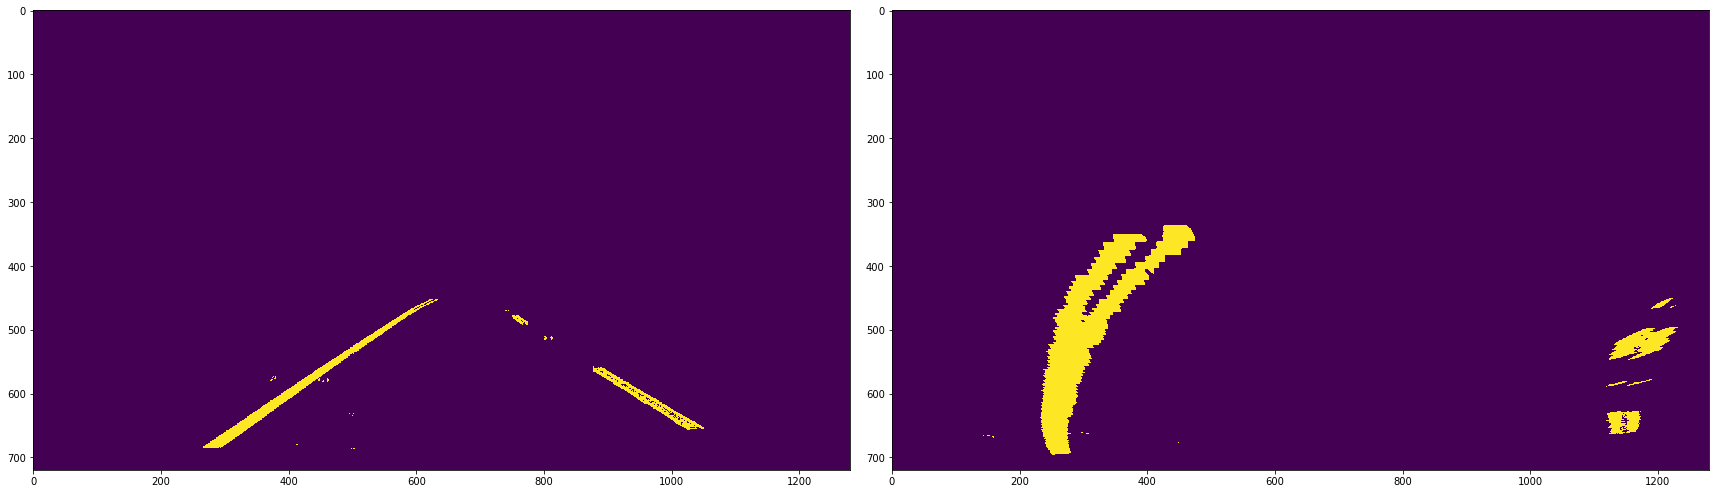

In [6]:
#TODO: teorically it should work but couldn make it work due to wrong lane detection. 

offset =100

img_raw = cv2.imread(fname)
img = get_thresholded_image(img_raw)

# lane line coordinates in a cropped box 
cords = np.argwhere(img>0); cords = cords[cords[:,0]> 460]
lcord, rcord = cords[cords[:,1] < 600], cords[cords[:,1] > 700]
lcord, rcord = lcord[lcord[:,1] > 220], rcord[rcord[:,1] < 1300]
# get lane line extrema coordinates
lmin, lmax = np.min(lcord, axis=0), np.max(lcord, axis=0)
rmin, rmax = np.min(rcord, axis=0), np.max(rcord, axis=0)
p0, p1 = (lmin[1], lmax[0]), (lmax[1], lmin[0])
p2, p3 = (rmin[1], rmin[0]), (rmax[1], rmax[0])


src = np.array([p0,p1,p2,p3], dtype=np.float32)
#dst = np.array([(p0[0]+offset,p0[1]), (p0[0]+offset,0), (p3[0]-offset,0),( p3[0]-offset,p3[1])], dtype=np.float32)

dst = np.array([p0, (p0[0],p1[1]), (p3[0],p2[1]), p3], dtype=np.float32)

warped, M, Minv = corners_unwarp(img,src,dst, calibration['mtx'], calibration['dist'])
plot_two_image(img, warped)



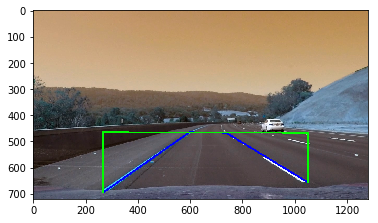

In [7]:

image = cv2.imread(fname)

image = cv2.line(image, ( src[0][0],  src[0][1]), ( src[1][0],  src[1][1]),  (0,0,255), thickness=6)
image = cv2.line(image, ( src[-1][0],  src[-1][1]), ( src[-2][0],  src[-2][1]),  (0,0,255), thickness=6)
image = cv2.line(image, ( src[1][0],  src[1][1]), ( src[-2][0],  src[-2][1]),  (0,0,255), thickness=3)

src=dst
image = cv2.line(image, ( src[0][0],  src[0][1]), ( src[1][0],  src[1][1]),  (0,255,0), thickness=6)
image = cv2.line(image, ( src[-1][0],  src[-1][1]), ( src[-2][0],  src[-2][1]),  (0,255,0), thickness=6)
image = cv2.line(image, ( src[1][0],  src[1][1]), ( src[-2][0],  src[-2][1]),  (0,255,0), thickness=3)
plt.imshow(image)


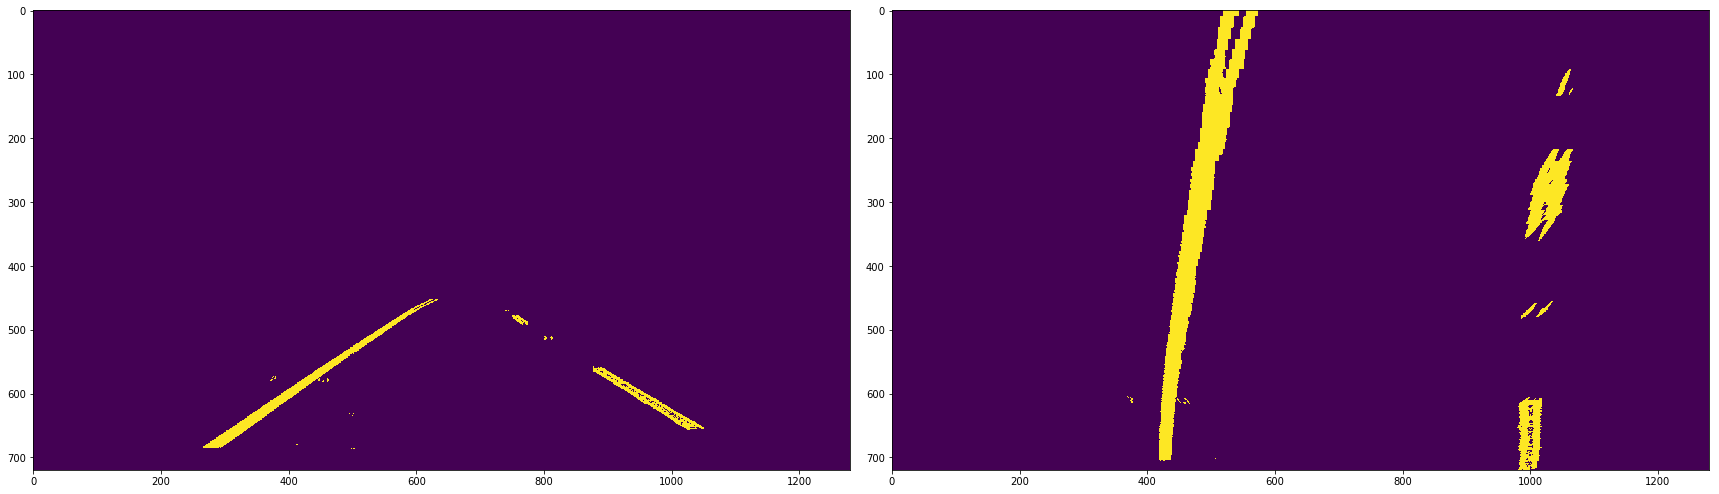

In [8]:

src = np.float32([[220, 720],[580, 460],[710, 460],[1100, 720]])
offset = 200
# 4 destination points
dst = np.float32([[src[0][0]+offset, 720],[src[0][0]+offset, 0],[src[-1][0]-offset, 0],[src[-1][0]-offset, 720]])

img_raw = cv2.imread(fname)
img = get_thresholded_image(img_raw)
# transform matrix
warped, M, Minv = corners_unwarp(img,src,dst, calibration['mtx'], calibration['dist'])
plot_two_image(img, warped)

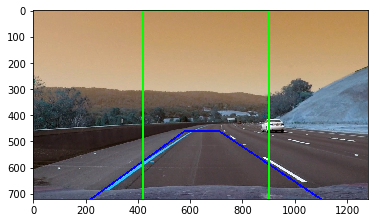

In [9]:
#to visualize perspective transform points

image = cv2.imread(fname)

image = cv2.line(image, ( src[0][0],  src[0][1]), ( src[1][0],  src[1][1]),  (0,0,255), thickness=6)
image = cv2.line(image, ( src[-1][0],  src[-1][1]), ( src[-2][0],  src[-2][1]),  (0,0,255), thickness=6)
image = cv2.line(image, ( src[1][0],  src[1][1]), ( src[-2][0],  src[-2][1]),  (0,0,255), thickness=3)

src=dst
image = cv2.line(image, ( src[0][0],  src[0][1]), ( src[1][0],  src[1][1]),  (0,255,0), thickness=6)
image = cv2.line(image, ( src[-1][0],  src[-1][1]), ( src[-2][0],  src[-2][1]),  (0,255,0), thickness=6)
image = cv2.line(image, ( src[1][0],  src[1][1]), ( src[-2][0],  src[-2][1]),  (0,255,0), thickness=3)
plt.imshow(image)


In [10]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    threshold =  np.floor_divide(img.shape, 2)
    
    bottom_half = img[threshold[0]:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

hist = hist(warped)

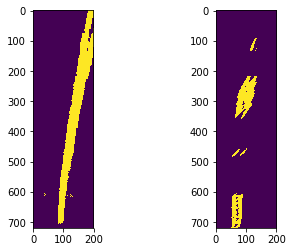

In [11]:
MARGIN = 100
img=img = warped.copy()
lhist, rhist = hist[:600], hist[600:]
lcenter, rcenter = np.argmax(lhist), np.argmax(rhist)+640

llo, lhi, rlo, rhi = lcenter-MARGIN, lcenter+MARGIN, rcenter-MARGIN, rcenter+MARGIN
plt.subplot(1,2,1).imshow(img[:,llo:lhi]); plt.subplot(1,2,2).imshow(img[:,rlo:rhi])

Above example of lane lines. 

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =   leftx_current - (margin) # Update this
        win_xleft_high =  leftx_current + (margin) # Update this
        
        win_xright_low =  rightx_current - (margin)   # Update this
        win_xright_high = rightx_current + (margin)  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, visualize=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    if(visualize):
        
        # draw the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    
    return left_fit,right_fit, leftx, lefty, rightx, righty, ploty, out_img


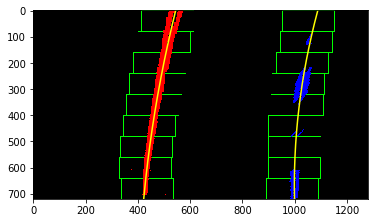

In [13]:
left_fit,right_fit, leftx, lefty, rightx, righty, ploty, out_img = fit_polynomial(warped,visualize=True)
plt.imshow(out_img)

In [14]:



def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped, left_fit,right_fit, visualize=False):
    
    
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if(visualize):
        
        # draw the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit, right_fit, ploty, result

In [15]:
print(left_fit)
print(right_fit)

[  1.07265770e-04  -2.46643534e-01   5.44520200e+02]
[  2.00198440e-04  -2.67626324e-01   1.08785753e+03]


[  1.07265770e-04  -2.46643534e-01   5.44520200e+02]
[  2.00198440e-04  -2.67626324e-01   1.08785753e+03]

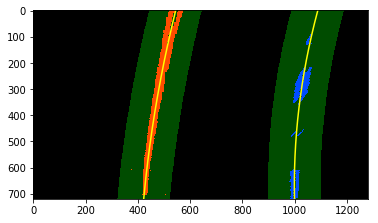

In [16]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fit, right_fit, ploty, result = search_around_poly(warped,left_fit,right_fit,visualize=True)

# View your output
plt.imshow(result)

In [17]:
def measure_curvature_pixels(left_fit,right_fit,ploty ):
 
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]  *y_eval + left_fit[1]) **2)**1.5) / np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad =((1 + (2*right_fit[0] *y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]) ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad

In [18]:
measure_curvature_pixels(left_fit,right_fit,ploty)

(4733.5770657634948, 2499.0596919611226)

In [19]:


def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [20]:
def final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset):
    
    
    """
    Final lane line prediction visualized and overlayed on top of original image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')  # NOTE: Hard-coded image dimensions

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curve + right_curve)/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.1f m' % vehicle_offset
    result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    return result

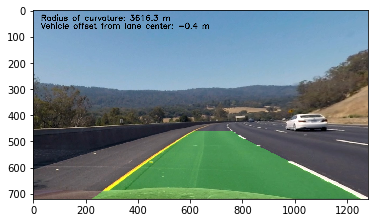

In [21]:
orig = mpimg.imread(fname)


out_image_file = fname.split('.')[0] + '.png'  # write to png format

left_curve, right_curve = measure_curvature_pixels(left_fit,right_fit,ploty)

bottom_y = undist.shape[0] - 1
bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

xm_per_pix = 3.7/700 # meters per pixel in x dimension
vehicle_offset *= xm_per_pix

img = final_viz(undist, left_fit, right_fit, Minv, left_curve, right_curve, vehicle_offset)



plt.imshow(img)
plt.savefig('output_images/' + out_image_file)



In [22]:

def image_pipeline(img_in , visualize=False):
    
    global mtx, dist, left_line, right_line, detected
    global left_curve, right_curve, left_lane_inds, right_lane_inds
    
    undist  = cv2.undistort(img_in, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
    #TODO: make distorted one work too
    img = get_thresholded_image(img_in)
    
    src = np.float32([[220, 720],[580, 460],[710, 460],[1100, 720]])
    offset = 200
    # 4 destination points
    dst = np.float32([[src[0][0]+offset, 720],[src[0][0]+offset, 0],[src[-1][0]-offset, 0],[src[-1][0]-offset, 720]])

    # transform matrix
    # TODO: use undistort function. 
    warped, M, Minv = corners_unwarp(img,src,dst, calibration['mtx'], calibration['dist'])
    
    # Get moving average of line fit coefficients
    
    
    if detected==False: 
        left_fit_,right_fit_, leftx, lefty, rightx, righty, ploty, out_img = fit_polynomial(warped)
        left_fit_ = left_line.add_fit(left_fit_)
        right_fit_ = right_line.add_fit(right_fit_)
        detected=True
    else:
        left_fit_ = left_line.get_fit()
        right_fit_ = right_line.get_fit()
        left_fit_, right_fit_, ploty, out_img = search_around_poly(warped,left_fit_,right_fit_)
        left_fit_ = left_line.add_fit(left_fit_)
        right_fit_ = right_line.add_fit(right_fit_)
        
        #print('else:', left_fit_, right_fit_, ploty, out_img)
    
    left_curve, right_curve = measure_curvature_pixels(left_fit_,right_fit_,ploty)
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit_[0]*(bottom_y**2) + left_fit_[1]*bottom_y + left_fit_[2]
    bottom_x_right = right_fit_[0]*(bottom_y**2) + right_fit_[1]*bottom_y + right_fit_[2]
    vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix
    
   
    
    result = final_viz(undist, left_fit_, right_fit_, Minv, left_curve, right_curve, vehicle_offset)
    if visualize:
        plot_two_image(undist,result)
        # View your output
    return result    

In [23]:



# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        """
        n is the window size of the moving average
        """
        self.n = n
        self.detected = False

        # Polynomial coefficients: x = A*y^2 + B*y + C
        # Each of A, B, C is a "list-queue" with max length n
        self.A = []
        self.B = []
        self.C = []
        # Average of above
        self.A_avg = 0.
        self.B_avg = 0.
        self.C_avg = 0.

    def get_fit(self):
        return (self.A_avg, self.B_avg, self.C_avg)

    def add_fit(self, fit_coeffs):
        """
        Gets most recent line fit coefficients and updates internal smoothed coefficients
        fit_coeffs is a 3-element list of 2nd-order polynomial coefficients
        """
        # Coefficient queue full?
        q_full = len(self.A) >= self.n

        # Append line fit coefficients
        self.A.append(fit_coeffs[0])
        self.B.append(fit_coeffs[1])
        self.C.append(fit_coeffs[2])

        # Pop from index 0 if full
        if q_full:
            _ = self.A.pop(0)
            _ = self.B.pop(0)
            _ = self.C.pop(0)

        # Simple average of line coefficients
        self.A_avg = np.mean(self.A)
        self.B_avg = np.mean(self.B)
        self.C_avg = np.mean(self.C)

        return (self.A_avg, self.B_avg, self.C_avg)



In [24]:
from moviepy.editor import VideoFileClip

window_size=9
left_line = Line(n=window_size)
right_line = Line(n=window_size)

detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0.  # radius of curvature for left and right lanes
left_lane_inds, right_lane_inds = None, None  # for calculating curvature

def annotate_video(input_file, output_file):
    """ Given input_file video, save annotated video to output_file """
    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(image_pipeline)
    annotated_video.write_videofile(output_file, audio=False)

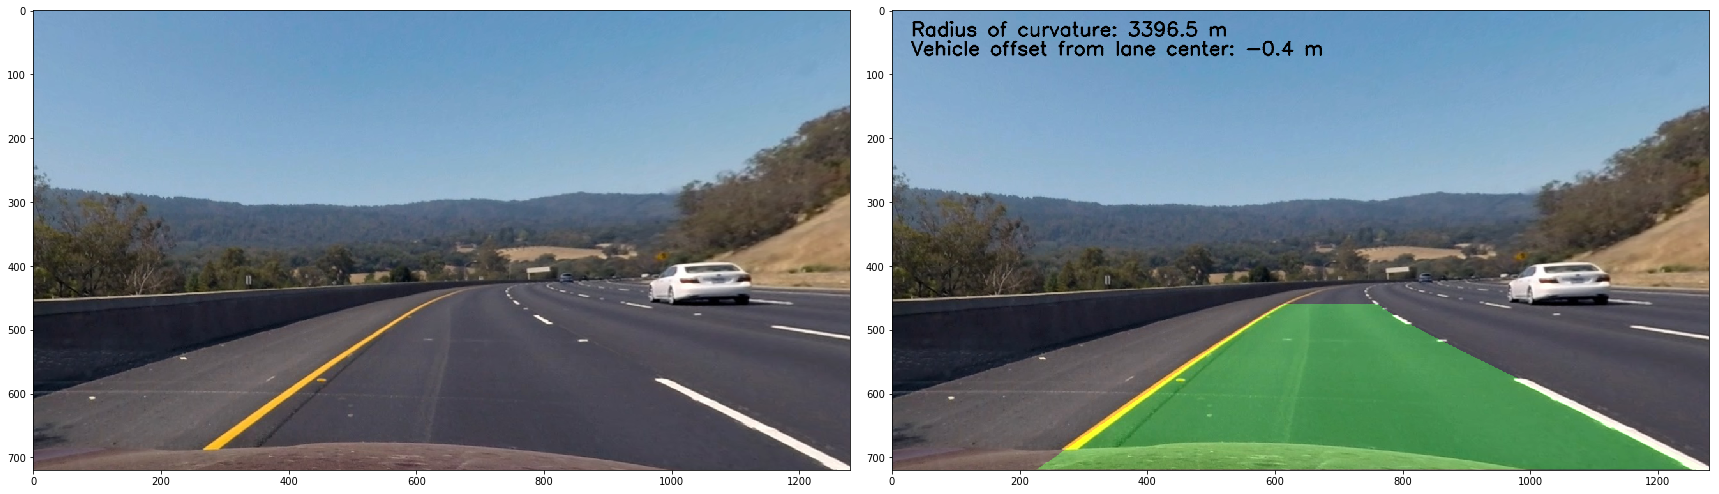

array([[[121, 160, 199],
        [120, 159, 198],
        [120, 159, 198],
        ..., 
        [114, 160, 196],
        [114, 159, 196],
        [114, 158, 195]],

       [[121, 160, 199],
        [120, 159, 198],
        [120, 159, 198],
        ..., 
        [114, 160, 196],
        [114, 159, 196],
        [114, 158, 195]],

       [[122, 161, 200],
        [121, 160, 199],
        [120, 159, 198],
        ..., 
        [114, 160, 196],
        [114, 159, 196],
        [115, 159, 196]],

       ..., 
       [[104,  84,  79],
        [103,  83,  77],
        [103,  83,  77],
        ..., 
        [244, 243, 234],
        [244, 241, 234],
        [248, 243, 237]],

       [[107,  88,  82],
        [108,  89,  83],
        [109,  90,  84],
        ..., 
        [250, 255, 238],
        [248, 255, 236],
        [247, 247, 235]],

       [[116,  97,  91],
        [116,  97,  91],
        [117,  98,  92],
        ..., 
        [253, 255, 240],
        [251, 255, 238],
        [248, 255,

In [25]:
fname = 'test_images/test{}.jpg'.format(3)
img_raw = mpimg.imread(fname)
image_pipeline(img_raw, True)


In [26]:
annotate_video('project_video.mp4', 'out.mp4')

    
    

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 1260/1261 [08:19<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

